# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.
4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

Primero cargamos los paquetes que necesitamos.

In [1]:
import pandas as pd

import itertools

import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter, DayLocator

import seaborn as sns

import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

Cargamos los datos que tenemos y veamos un poco de la información que tenemos.

In [2]:
# Cargamos datos
df_original = pd.read_csv("/datasets/taxi.csv")

# Veamos un sample rápido
df_original.sample(n=5, random_state=1)

,datetime,num_orders
15245,2018-06-14 20:50:00,29
16246,2018-06-21 19:40:00,4
21918,2018-07-31 05:00:00,7
3782,2018-03-27 06:20:00,0
22759,2018-08-06 01:10:00,26


Vemos que tenemos nuestros datos, haremos el cabio de índice para que sea datetime.

In [3]:
# Cambiamos el tipo y volvemos el índice
df = df_original.copy()
df.datetime = df.datetime.astype("datetime64")

df = df.set_index("datetime", drop=True)

# Veamos un sample rápido
df.sample(n=5, random_state=1)

,num_orders
datetime,
2018-06-14 20:50:00,29
2018-06-21 19:40:00,4
2018-07-31 05:00:00,7
2018-03-27 06:20:00,0
2018-08-06 01:10:00,26


Ahora verifiquemos que nuestros datos estan en órden cronológico:

In [4]:
# Ordenamos vía índice
df = df.sort_index()

df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Se ve mejor, aunque nuestros datos parecen tener una cadencia diferente a la que necesitamos de una hora: usemos _resample_ para esto.

In [5]:
# Resampleamos
df = df.resample("1H").sum()

# Un sample
df.sample(n=5, random_state=1)

,num_orders
datetime,
2018-04-05 17:00:00,38
2018-03-24 05:00:00,27
2018-06-22 08:00:00,73
2018-08-02 06:00:00,18
2018-06-25 10:00:00,100


Mucho mejor, ahora veamos cual es el rango de valores que abarca usando _info_.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Interesante, tenemos desde marzo hasta el final de agosto. Al igual parece que no tenemos valores nulos, es bueno saberlo: menos trabajo. Procederemos a realizar el análisis de los datos para ver como se comporta.

## Análisis

Primero grafiquemos el número de órdenes a traves de tiempo.

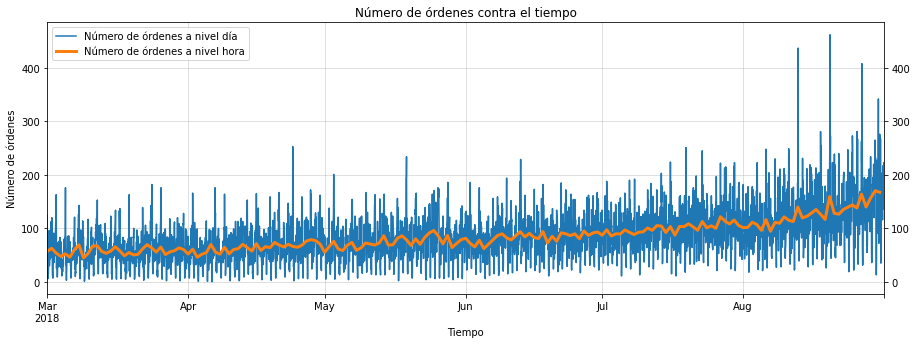

In [7]:
fig, axes = plt.subplots(1,1,figsize=(15,5))

# Graficamos los valores
#axes.scatter(x = df.reset_index().datetime, y = df.reset_index().num_orders, alpha=0.2, s=20, color="grey")
df.num_orders.plot(ax=axes)
#axes.plot(df.reset_index().datetime, df.reset_index().num_orders)
#axes.plot(
#    df.resample('1D').mean().reset_index().datetime,
#    df.resample('1D').mean().reset_index().num_orders,
#    linewidth=3, color="C0"
#)
#axes.plot(df.reset_index().datetime, df.reset_index().num_orders.rolling(7).std(), linewidth=1.5, color="C1")
df.resample('1D').mean().reset_index().plot("datetime", linewidth=3, color="C1", ax=axes)

axes.set_title("Número de órdenes contra el tiempo")
axes.legend(["Número de órdenes a nivel día", "Número de órdenes a nivel hora"])
axes.set_ylabel("Número de órdenes")
axes.set_xlabel("Tiempo")

axes.grid(which='minor', axis= "y", alpha=0.2)
axes.grid(which='major', alpha=0.5)

axes.tick_params(axis="x", which="minor", bottom=False)
#axes.tick_params(axis= "y", which = "both", labelright=True)
axes.tick_params(which= "both", left=True, right=True, labelright=True)

plt.show()

Podemos ver que tenemos un comportamiento que va aumentando de media poco a poco conforme pasa el tiempo: a nivel de hora los valores se dispersan bastante (la línea azul), pero con los datos a nivel día (línea naranja) se ve el promedio diario; es claro que la media aumenta sensiblemente como se mencionaba. Para tener un mejor análisis, haremos el análisis de la serie temporal.

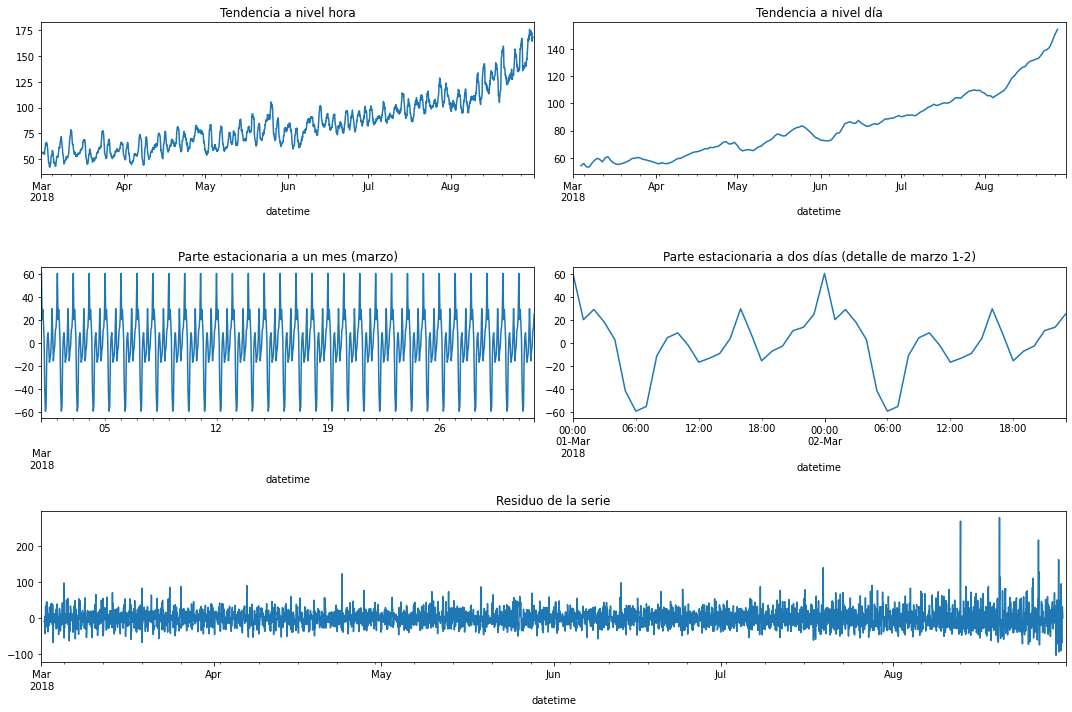

In [8]:
# descomponemos
decomposed = seasonal_decompose(df.num_orders)
decomposed_1D = seasonal_decompose(df.resample('1D').mean().num_orders)

fig = plt.figure(figsize=(15,10))
ax_dict = fig.subplot_mosaic(
    [
        ["trend", "trend_1d"],["seasonal", "seasonal_dia"],["residuo", "residuo"]
    ]
)

# Tendencias
decomposed.trend.plot(ax=ax_dict["trend"])
decomposed_1D.trend.plot(ax=ax_dict["trend_1d"])

ax_dict["trend"].set_title("Tendencia a nivel hora")
ax_dict["trend_1d"].set_title("Tendencia a nivel día")

# Estacionaria
decomposed.seasonal["2018-03"].plot(ax=ax_dict["seasonal"])
decomposed.seasonal["2018-03-01":"2018-03-02"].plot(ax=ax_dict["seasonal_dia"])

ax_dict["seasonal"].set_title("Parte estacionaria a un mes (marzo)")
ax_dict["seasonal_dia"].set_title("Parte estacionaria a dos días (detalle de marzo 1-2)")

# Residuo
decomposed.resid.plot(ax=ax_dict["residuo"])
ax_dict["residuo"].set_title("Residuo de la serie")

plt.tight_layout()
plt.show()

Tenemos bastante que mencionar: primero con la tendencia a nivel hora es claro que el comportamiento es ascendente y se aprecia mejor cuando remuestramos los datos a un día como en la segunda figura: es claro que la media por día va en aumento. De la estacionalidad, es claro que a nivel mes el patrón se repite pero se requiere un zoom mayor: hay una clara frecuencia diaria en la que se tiene un descenso a las 6 de la mañana y un pico a medianoche ( y un pico a las 5 pm cuando la gente sale del trabajo). Por la parte del ruido, realmente no se puede decir demasiado más que se mantiene alrededor del cero y hay algunos picos importantes a mediados de agosto.

Veamos que sucede con la tendencia pero a nivel de un solo mes, Marzo.

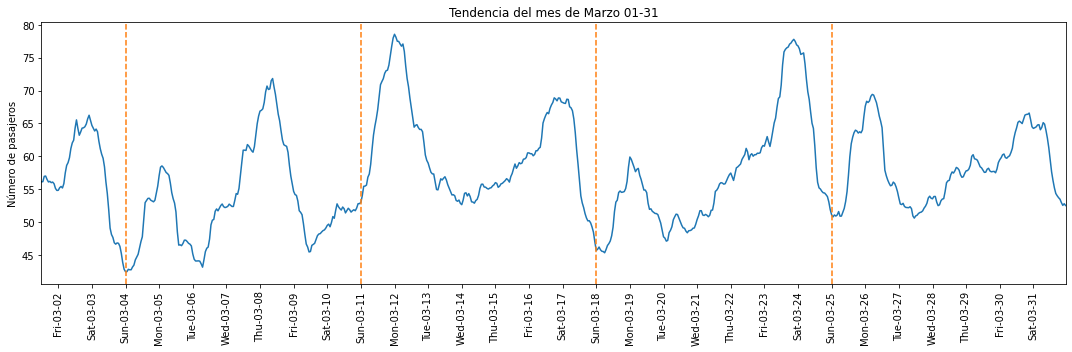

In [9]:
fig, axes = plt.subplots(1,1, figsize=(15,5))

# Tendencias
axes.plot(decomposed.trend["2018-03-01":"2018-03-31"])

# Definimos los ticks
axes.xaxis.set_major_locator(DayLocator())
axes.xaxis.set_major_formatter(DateFormatter("%a-%m-%d"))
axes.tick_params(axis="x", labelrotation= 90)

axes.set_title("Tendencia del mes de Marzo 01-31")
axes.set_ylabel("Número de pasajeros")
axes.margins(x=0)

for sunday in [17594, 17601, 17608, 17615]:
    axes.axvline(sunday, color="C1", linestyle="--")

plt.tight_layout()
plt.show()

Se han colocado líneas verticales que representan los domingos del mes: tenemos muchos picos y valles, y pareciera que los domingos usualmente se tiene una caída del número de pasajeros, pero no siempre es el caso; usualmente los lunes hay un pico local justo después del valle de fin de semana. Podríamos resumirlo en que los fines de semana (como la experiencia cotidiana indica) la gente usa menos el servicio de taxi. Como tenemos este patrón cada 24 horas, usaremos un lag de 24 para crear nuestras características.

## Creación de características
Poblaremos nuestro dataset con las características necesarias para realizar los modelos.

In [10]:
# Creamos las features
df["mes"] = df.index.month
df["dia"] = df.index.day
df["dia_semana"] = df.index.dayofweek
df["hora"] = df.index.hour

# Veamos otro sample
df.sample(n=5, random_state=1)

,num_orders,mes,dia,dia_semana,hora
datetime,,,,,
2018-04-05 17:00:00,38,4,5,3,17
2018-03-24 05:00:00,27,3,24,5,5
2018-06-22 08:00:00,73,6,22,4,8
2018-08-02 06:00:00,18,8,2,3,6
2018-06-25 10:00:00,100,6,25,0,10


Ya se ve mucho mejor, pero todavía podemos agregarle algunas características más: características de desfase y de media móvil. Para los primeros usaremos usaremos de los valores de 1 a 8 (que corresponde a apróximadamente una jornada laboral) y un desfase de 24 horas (por la estacionalidad); usaremos una media móvil de 14 días ya que es apróximadamente medio mes.

In [11]:
# Features de desfase
for lag in [x for x in range(1, 8+1)] + [24]:
        df["lag_{}".format(lag)] = df["num_orders"].shift(lag)
        
# Features de media móvil sin contar el mismo día
df["media_movil_14"] = df["num_orders"].shift(1).rolling(14).mean()

#for item in [7, 14]:
#    df["media_movil_{}".format(item)] = df["num_orders"].shift().rolling(item).mean()

# Desviación estándar
#df['std'] = df["num_orders"].rolling(14).std()
    
# Mostremos los primeros valores
df.head(25)
#df.sample(n=5, random_state=1)

,num_orders,mes,dia,dia_semana,hora,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_24,media_movil_14
datetime,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,3,1,3,5,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,3,1,3,6,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 08:00:00,34,3,1,3,8,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN


Ya todo se ve en órden con las características, procedamos a analizar nuestros datos.

## Entrenamiento de modelos

Procedamos a realizar el entrenamiento de nuestros modelos con los datos: primero procederemos a dividir nuestros datos en sus conjuntos apropiados con un conjunto de prueba 10% del total.

In [12]:
# Hasta el momento no habíamos tenido problemas, pero necesitaremos quitar los valores nulos de nuestro dataset:
# algunos valores serán vacíos cuando se hace el shift de los datos.
df = df.dropna()

#train, test = train_test_split(df, shuffle=False, test_size=0.1)
train_valid, test = train_test_split(df, shuffle=False, test_size=0.1)
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.111)

features_train = train.drop("num_orders", axis=1)
features_test = test.drop("num_orders", axis=1)
features_valid = valid.drop("num_orders", axis=1)

target_train = train.num_orders
target_test = test.num_orders
target_valid = valid.num_orders

# Veamos los tamaños
print(f"Características de entrenamiento: {features_train.shape}")
print(f"Características de validación: {features_valid.shape}")
print(f"Características de prueba: {features_test.shape}\n")

print(f"Objetivos de entrenamiento: {target_train.shape}")
print(f"Objetivos de validación: {target_valid.shape}")
print(f"Objetivos de prueba: {target_test.shape}")

Características de entrenamiento: (3513, 14)
Características de validación: (439, 14)
Características de prueba: (440, 14)

Objetivos de entrenamiento: (3513,)
Objetivos de validación: (439,)
Objetivos de prueba: (440,)


A partir de aquí intentaremos con tres modelos para nuestro estudio: de regresión lineal, con LightGBM, y de bosque aleatorio. Antes de eso, sin embargo, haremos un _sanity check_ de nuestra serie temporal.

### Sanity Check

In [13]:
# Haremos el sanity check con los valores justamente anteriores x(t-1)
predictions_sanity = valid.shift()
predictions_sanity.iloc[0] = train.iloc[-1]
score_sanity = mean_squared_error(target_valid, predictions_sanity.num_orders)**0.5
print(
    f"RMSE para el sanity check {score_sanity}"
)

RMSE para el sanity check 47.344157488454385


Nuestro _sanity check_ muestra un valor bastante bueno considerando que no hemos realizado ningún entrenamiento: esperamos que nuestros modelos sean mucho mejores.

### Modelo de regresión lineal

In [14]:
model_lineal = LinearRegression()

model_lineal.fit(features_train, target_train)

predictions_lineal = model_lineal.predict(features_valid)

score_lineal = mean_squared_error(target_valid, predictions_lineal)**0.5

print(
    f"RMSE para el modelo de regresión lineal {score_lineal}"
)

RMSE para el modelo de regresión lineal 35.4460251096846


Nuestro resultado ha mejorado bastante desde nuestro sanity check: parece que vamos por buen camino pero todavía podemos mejorar bastante.

### Modelo con LightGBM

In [15]:
# Los parametros a buscar
parameters = {
    "learning_rate":[0.01, 0.5],
    "num_leaves": [5, 10, 15],
    "max_depth": [10, 20, 30, -1]
}

# Definimos los parametros
keys, values = zip(*parameters.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

# Inicializamos para crear al final el dataframe de resultados -- es menos intensivo crear listas que 
# hacer concat a un dataframe vacío aparentemente según la doc
dict_results_lightgbm = {"learning_rate": [], "num_leaves": [], "max_depth": [], "rmse": []}

# Buscamos los mejores
for item in tqdm(permutations_dicts):
    model_lightgbm = LGBMRegressor(
        learning_rate=item["learning_rate"], num_leaves=item["num_leaves"], max_depth=item["max_depth"],
        random_state=1
    )
    model_lightgbm.fit(features_train, target_train)
    predictions_lightgbm = model_lightgbm.predict(features_valid)
    score_lightgbm = mean_squared_error(target_valid, predictions_lightgbm)**0.5    
    
    # Guardamos el registro
    for key in ["learning_rate", "num_leaves", "max_depth"]:
        dict_results_lightgbm[key].append(item[key])
    dict_results_lightgbm["rmse"].append(score_lightgbm)
    
#grid_lightgbm = GridSearchCV(
#    estimator=model_lightgbm, param_grid=parameters, scoring='neg_mean_squared_error'
#)

# Ajustamos
#grid_lightgbm.fit(features_train, target_train)

  0%|          | 0/24 [00:00<?, ?it/s]

Mostramos los resultados como una mapa de calor para apreciar mejor nuestros resultados.

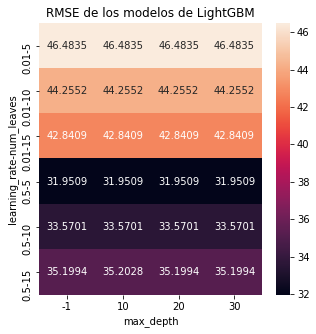

In [16]:
# Creamos un dataframe
df_tuning_lightgbm = pd.DataFrame(dict_results_lightgbm)

# Graficamos
fig, axes = plt.subplots(1,1, figsize=(5, 5))


sns.heatmap(
    df_tuning_lightgbm.pivot_table(values="rmse", index=["learning_rate", "num_leaves"], columns="max_depth"),
    annot=True,
    fmt=".4f",
    ax=axes
)

axes.set_title("RMSE de los modelos de LightGBM")
plt.show()

En el caso de los parámetros parece que los valores importantes son la tasa de aprendizaje y el número de hojas: la profundidad no cambia demasiado el resultado. Tomaremos como mejores parámetros `learning_rate` de 0.5, `num_leaves` de 5, y `max_depth` de 20 (ni muy grande ni muy pequeño).

### Modelo de bosque aleatorio

In [17]:
# Los parametros a buscar
parameters = {
    "max_depth": [5, 10, 15, 20, 25],
    "n_estimators": [10, 30, 50, 100]
}

# Definimos los parametros
keys, values = zip(*parameters.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

# Inicializamos 
dict_results_forest = {"n_estimators": [], "max_depth": [], "rmse": []}

# Buscamos los mejores
for item in tqdm(permutations_dicts):
    model_forest = RandomForestRegressor(
        n_estimators=item["n_estimators"], max_depth=item["max_depth"],
        random_state=1
    )
    model_forest.fit(features_train, target_train)
    predictions_forest = model_forest.predict(features_valid)
    score_forest = mean_squared_error(target_valid, predictions_forest)**0.5    
    
    # Guardamos el registro
    for key in ["n_estimators", "max_depth"]:
        dict_results_forest[key].append(item[key])
    dict_results_forest["rmse"].append(score_forest)
    
# Buscamos los parametros
#grid_forest = GridSearchCV(
#    estimator=model_forest, param_grid=parameters, scoring='neg_mean_squared_error', verbose=2
#)

# Ajustamos
#grid_forest.fit(features_train, target_train)

  0%|          | 0/20 [00:00<?, ?it/s]

Veamos ahora los resultados que tenemos:

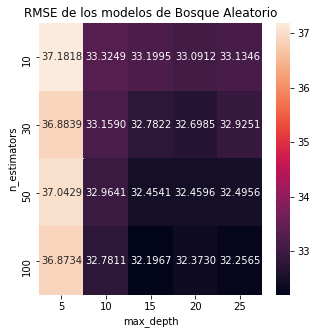

In [18]:
# Creamos un dataframe
df_tuning_forest = pd.DataFrame(dict_results_forest)

# Graficamos
fig, axes = plt.subplots(1,1, figsize=(5, 5))

sns.heatmap(
    df_tuning_forest.pivot_table(values="rmse", index="n_estimators", columns="max_depth"),
    annot=True,
    fmt=".4f",
    ax=axes
)

axes.set_title("RMSE de los modelos de Bosque Aleatorio")
plt.show()

Este modelo es muy bueno pero LightGBM tiene una ligera mejoría, usaremos ese con los párametros mencionados para nuestro conjunto de prueba.

## Prueba del modelo

In [19]:
# Definimos el modelo
modelo_final = LGBMRegressor(learning_rate=0.5, num_leaves=5, max_depth=20, random_state=1)

# Juntamos de nuevo nuestros conjuntos de train y test
df_final_train = pd.concat([features_train, features_valid])
df_final_target = pd.concat([target_train, target_valid])

# Trabajamos el modelo
modelo_final.fit(df_final_train, df_final_target)
predictions_final = modelo_final.predict(features_test)
score_final = mean_squared_error(target_test, predictions_final)**0.5    

# Mostramos
print(
    f"RMSE para el modelo con el conjunto de prueba {score_final}"
)

RMSE para el modelo con el conjunto de prueba 40.98635111059102


Hemos obtenido un RMSE de ~41, el cual cumple al ser menor de nuestro objetivo de 48: obviamente no es tan bueno como cuando se hacen los entrenamientos para los modelos debido a que tenemos datos desconocidos en el conjunto de prueba, pero es aceptable. Por puro ejercicio, comparemos los valores reales contra los predichos en una gráfica para ese modelo.

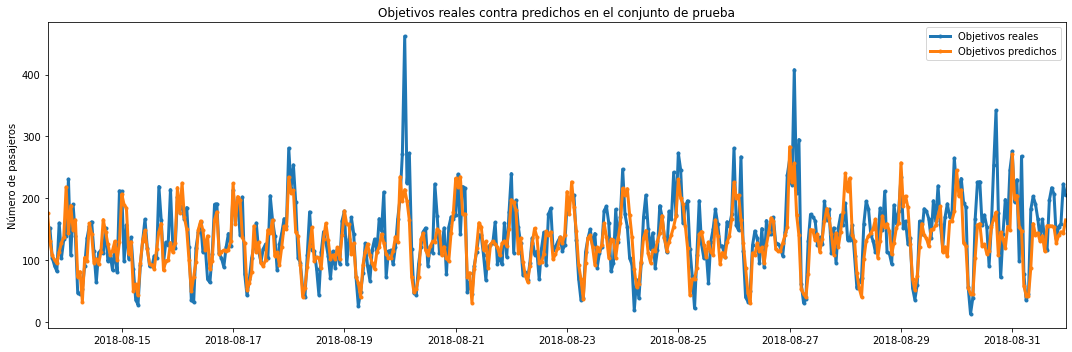

In [20]:
# Creemos un dataframe con los datos de test mas los predichos
df_final = features_test.copy()

df_final["target"] = target_test
df_final["prediction"] = predictions_final

# Ploteamos
fig, axes = plt.subplots(1,1, figsize=(15,5))

axes.plot(df_final.target, marker=".", linewidth=3, label="Objetivos reales")
axes.plot(df_final.prediction, marker=".", linewidth=3, label="Objetivos predichos")

# Definimos los ticks
axes.set_title("Objetivos reales contra predichos en el conjunto de prueba")
axes.set_ylabel("Número de pasajeros")
axes.margins(x=0)

axes.legend()
plt.tight_layout()
plt.show()

Viendo rápidamente la gráfica es claro que los valores predichos siempre son más modestos que los objetivos reales (es normal, las predicciones siempre pecan de ser "conservadoras") por lo que tiene la tendencia general bien, pero no es capaz de predecir completamente todos los picos.

## Conclusiones

Hemos cargado nuestros datos de serie temporal, importando las paqueterías necesarias. Empezamos revisando brevemente nuestros datos para ver si existen patrones interesantes o que nos puedan ser útiles, observando una clara tendencia a la alza en la media, y que existe una estacionalidad de 24 horas.

Posteriorente creamos las características, usando el lag de 1 a 8, y 24 horas; también agregamos la media móvil de 14 días; esto lo usamos para realizar el entrenamiento de tres modelos (y una prueba de cordura sin entrenar): de regresión lineal, LightGBM y de Bosque aleatorio para buscar una manera de predecir los valores que tenemos en nuestro dataset.

Nos damos cuenta de que el modelo de LightGBM es un claro ganador (aunque no por mucho) y procedemos a ver que la predicción es útil para los valores no tan extremos de nuestros datos (esto es, no es muy bueno prediciendo picos muy alejados de la media).